__Authors__: Bruno Javier Limon Avila, Carlo Volpe, Chiara Menchetti, Davide Di Virgilio

---

# Sentiment Analysis

This section revolves around Sentiment analysis, in an unsupervised way.

In [3]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from my_utils import *
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Davide\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data loading
Load the cleaned dataframe (computed in the jupyter notebook `0_TXA_data_preprocessing.ipynb`). 

In [2]:
#loading dataset
df=pd.read_csv("df_without_duplicates.csv")

In [3]:
# text cleaning and tokenization
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'),additional)

df['processed_text'] = df['content'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in x.split() if not i in swords])

C:\Users\chiar\AppData\Local\Temp\ipykernel_7128\163867834.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed_text'] = df['content'].str.lower()\


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66681 entries, 0 to 66680
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   content         66681 non-null  object
 1   fake            66681 non-null  int64 
 2   processed_text  66681 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [5]:
df

,content,fake,processed_text
0,what we can learn from the resurgence of covid...,0,"[learn, resurgence, covid, 19, spain]"
1,why approving a covid 19 vaccine too early cou...,0,"[approving, covid, 19, vaccine, early, could, ..."
2,not sure you have covid 19 here are the sympto...,0,"[sure, covid, 19, symptoms, coronavirus, flu, ..."
3,flu study highlights difficulty of achieving c...,0,"[flu, study, highlights, difficulty, achieving..."
4,resign or return the dilemma facing classroom ...,0,"[resign, return, dilemma, facing, classroom, t..."
...,...,...,...
66676,if you thought children couldn t get coronavir...,1,"[thought, children, get, coronavirus, alone, s..."
66677,a state lawmaker says children don t seem to b...,1,"[state, lawmaker, says, children, seem, gettin..."
66678,same shady characters involved with trump camp...,1,"[shady, characters, involved, trump, campaign,..."
66679,jerome corsi says dr anthony fauci s name appe...,1,"[jerome, corsi, says, dr, anthony, fauci, name..."


Our goal is to perform Sentiment Analysis on fake and reals news separately.

In [6]:
# splitting in two the dataset
df_fake=df[df["fake"]==1]
df_real=df[df["fake"]==0]

For a bettere visualization we decided to not consider the followings words: "coronavirus", "covid19", "covid", "u"

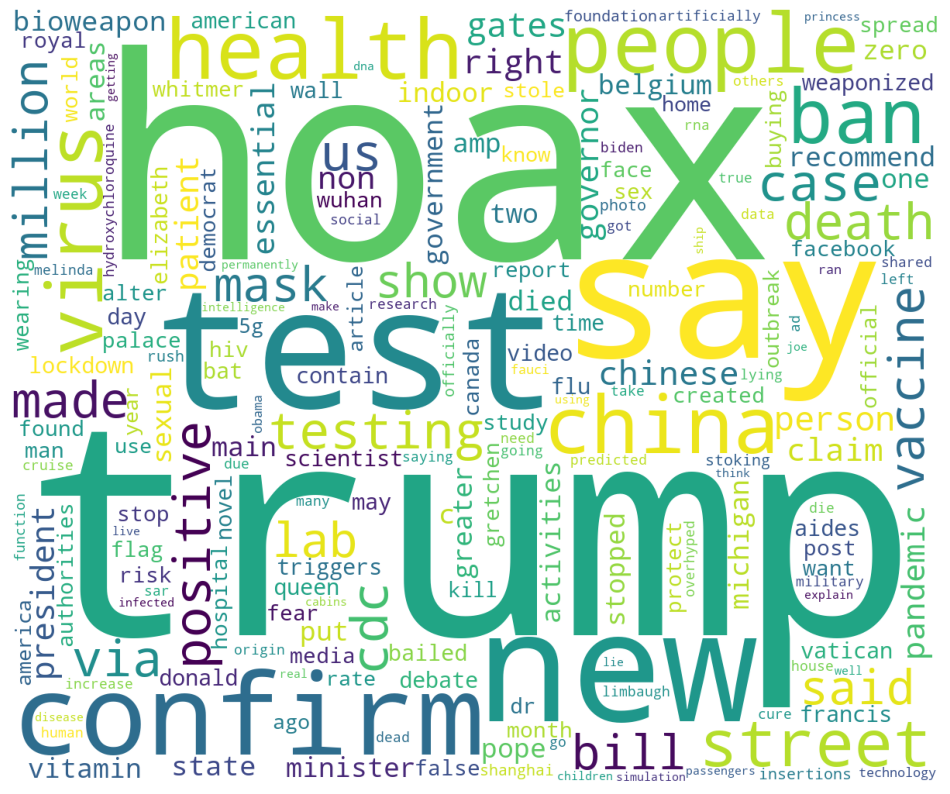

In [7]:
# wordcloud of the fake dataset
stopwords_1=["coronavirus", "covid19","covid",'u'] + list(STOPWORDS)
bigstring = df_fake['processed_text'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')


plt.figure(figsize=(12,12))
wordcloud = WordCloud(stopwords=stopwords_1,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

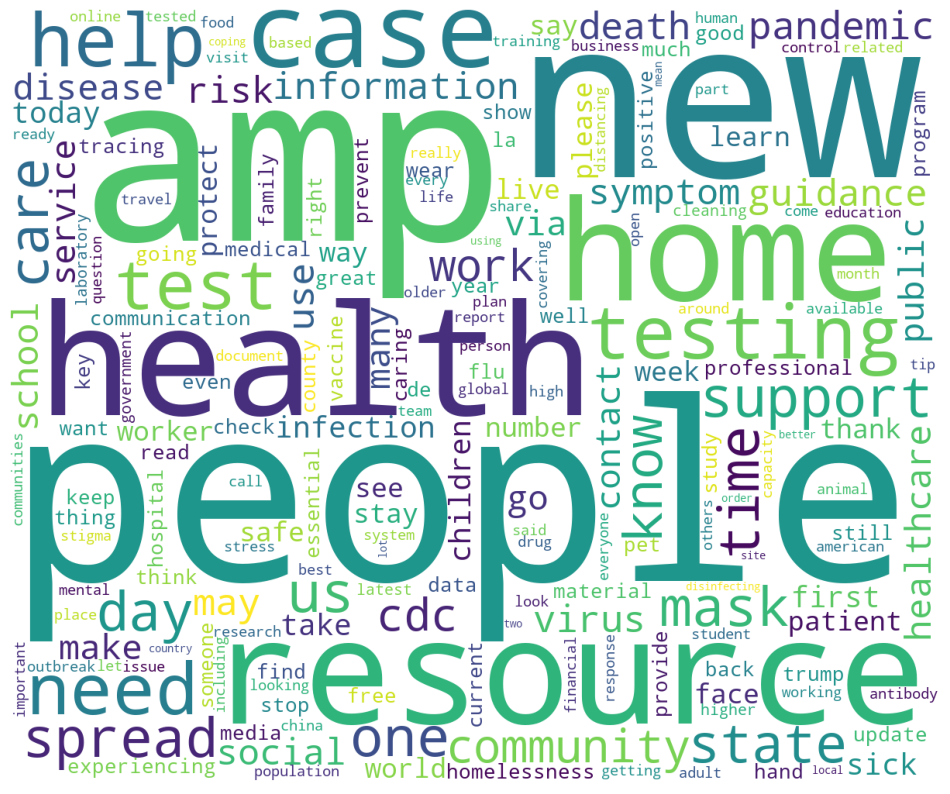

In [8]:
# wordcloud of the trues dataset
stopwords_1=["coronavirus", "covid19","covid",'u'] + list(STOPWORDS)
bigstring = df_real['processed_text'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')


plt.figure(figsize=(12,12))
wordcloud = WordCloud(stopwords=stopwords_1,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

<a id="fakenews"></a>
## Fake News Sentiment Analysis

In this subsection it is performed the sentiment analysis on the dataset only containing fake news and tweets.  The first step is the stemming:

In [10]:
# stemmization
from nltk.stem import PorterStemmer
ps = PorterStemmer()
df_fake['stemmer'] = df_fake['processed_text'].apply(lambda x: [ps.stem(i) for i in x if i != ''])

C:\Users\chiar\AppData\Local\Temp\ipykernel_19780\1562318095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake['stemmer'] = df_fake['processed_text'].apply(lambda x: [ps.stem(i) for i in x if i != ''])


In [11]:
df_fake.head(3)

,content,fake,processed_text,stemmer
3315,the u s cdc quietly updated their numbers in a...,1,"[u, cdc, quietly, updated, numbers, august, sh...","[u, cdc, quietli, updat, number, august, show,..."
3316,social media posts shared thousands of times a...,1,"[social, media, posts, shared, thousands, time...","[social, media, post, share, thousand, time, r..."
3317,the cdc updated the covid 19 number to admit t...,1,"[cdc, updated, covid, 19, number, admit, 6, 15...","[cdc, updat, covid, 19, number, admit, 6, 153,..."


To perform the sentiment analysis as an unsupervised task, it is used the Vader Lexicon. 

In [12]:
# sentiment analysis
import nltk.sentiment.vader as vd
from nltk import download
download('vader_lexicon')
sia = vd.SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chiar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
#tokenization and sentiment
from nltk.tokenize import word_tokenize
df_fake['sentiment_score'] = df_fake['stemmer'].apply(lambda x: sum([ sia.polarity_scores(i)['compound'] for i in word_tokenize( ' '.join(x) )]) )

C:\Users\chiar\AppData\Local\Temp\ipykernel_19780\2859099368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake['sentiment_score'] = df_fake['stemmer'].apply(lambda x: sum([ sia.polarity_scores(i)['compound'] for i in word_tokenize( ' '.join(x) )]) )


In [14]:
# number of positives, neutrals and negatives 
print('positives: ', len(df_fake[df_fake["sentiment_score"]>0]))
print('neutrals: ', len(df_fake[df_fake["sentiment_score"]==0]))
print('negatives: ', len(df_fake[df_fake["sentiment_score"]<0]))

positives:  595
neutrals:  631
negatives:  1102


To further the investigation into the connotation of the records in the dataset, the idea is to perform emotion analysis, for each of the three sentiments separately. 

In [15]:
# create the three datasets divided by the sentiment score: positive, negative and neutral
df_fake_positive = df_fake[df_fake["sentiment_score"]>0]
df_fake_neutral = df_fake[df_fake["sentiment_score"]==0]
df_fake_negative = df_fake[df_fake["sentiment_score"]<0]

### Negatives Emotion Analysis

For the emotion analysis the algorithms used are two. The first one is the following, by using the NRCLex function:

In [16]:
from nrclex import NRCLex

In [17]:
df_fake_negative['emotions'] = df_fake_negative['content'].apply(lambda x: NRCLex(x).affect_frequencies)
df_fake_negative.head(3)

C:\Users\chiar\AppData\Local\Temp\ipykernel_19780\882783072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake_negative['emotions'] = df_fake_negative['content'].apply(lambda x: NRCLex(x).affect_frequencies)


,content,fake,processed_text,stemmer,sentiment_score,emotions
3315,the u s cdc quietly updated their numbers in a...,1,"[u, cdc, quietly, updated, numbers, august, sh...","[u, cdc, quietli, updat, number, august, show,...",-0.5222,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
3316,social media posts shared thousands of times a...,1,"[social, media, posts, shared, thousands, time...","[social, media, post, share, thousand, time, r...",-0.5508,"{'fear': 0.1111111111111111, 'anger': 0.111111..."
3317,the cdc updated the covid 19 number to admit t...,1,"[cdc, updated, covid, 19, number, admit, 6, 15...","[cdc, updat, covid, 19, number, admit, 6, 153,...",-0.9193,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."


In [18]:
# create a df with only the content and the emotion
fakes_negative_emotions = pd.concat([df_fake_negative.content, df_fake_negative['emotions'].apply(pd.Series)], axis = 1)
fakes_negative_emotions = fakes_negative_emotions.drop(['anticip'], axis=1)
print(fakes_negative_emotions.shape)
fakes_negative_emotions.head(3)

(1102, 11)


,content,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
3315,the u s cdc quietly updated their numbers in a...,0.000000,0.000000,0.250000,0.000000,0.750000,0.000000,0.000000,0.000000,0.0,NaN
3316,social media posts shared thousands of times a...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.0,0.111111
3317,the cdc updated the covid 19 number to admit t...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN


As it can be observed, this library assigns a score to each emotion for each record. There can also be cases in which all the emotions are set to zero. To gather the approximate emotions for this dataset, the average of each emotion is computed. 

In [27]:
# mean value for each emotion
np.mean(fakes_negative_emotions)

c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


fear            0.089516
anger           0.062864
trust           0.101672
surprise        0.081636
positive        0.178935
negative        0.190340
sadness         0.081785
disgust         0.058544
joy             0.020842
anticipation    0.146936
dtype: float64

The highest emotion is the *negative* one, followed by the *positive* and *anticipation* ones. 

The next algorithm exploited is built upon the transformers library, and it uses a model called *EmoRoBERTa*.

In [28]:
from transformers import pipeline

c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [30]:
def get_emotion_label(text):
  return(emotion(text)[0]['label'])

The following is a time-consuming cell

The computation of this algorithm tend to be very slow. If the the file containing the result of this operations is available, `run_time_consuming_ops = False` can be used, and the time-consuming operations won't be executed, since the cell will simply load the result file to save time. 
If you want to run the time-consuming operations anyway, set `run_time_consuming_ops = True`.

In [43]:
# computing the emotion for the negatives dataset
run_time_consuming_ops = False

if run_time_consuming_ops:

    df_fake_negative['emotion_2'] = df_fake_negative['content'].apply(get_emotion_label)
    print('Time consuming operations performed!')

else:

    df_fake_negative = pd.read_csv('df_fake_negative.csv')
    print('Time-saving file loaded!')

Time-saving file loaded!


In [47]:
df_fake_negative.head(3)

,content,fake,processed_text,stemmer,sentiment_score,emotions,emotion_2
0,the u s cdc quietly updated their numbers in a...,1,"['u', 'cdc', 'quietly', 'updated', 'numbers', ...","['u', 'cdc', 'quietli', 'updat', 'number', 'au...",-0.5222,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",realization
1,social media posts shared thousands of times a...,1,"['social', 'media', 'posts', 'shared', 'thousa...","['social', 'media', 'post', 'share', 'thousand...",-0.5508,"{'fear': 0.1111111111111111, 'anger': 0.111111...",neutral
2,the cdc updated the covid 19 number to admit t...,1,"['cdc', 'updated', 'covid', '19', 'number', 'a...","['cdc', 'updat', 'covid', '19', 'number', 'adm...",-0.9193,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",neutral


In [3]:
df_fake_negative['processed_text'] = df_fake_negative['processed_text'].apply(lambda x: x.replace("'", ""))

In [4]:
bigstring = df_fake_negative['processed_text'].apply(lambda x: ''.join(x)).str.cat(sep='')
bigstring

'[u, cdc, quietly, updated, numbers, august, show, 6, coronavirus, deaths, completely, due, coronavirus, alone][social, media, posts, shared, thousands, times, retweeted, president, donald, trump, claim, u, centers, disease, control, prevention, cut, national, covid, 19, death, toll, 94, citing, cdc, comorbidity, chart][cdc, updated, covid, 19, number, admit, 6, 153, 504, deaths, recorded, actually, died, covid, 19][hydroxychloroquine, uganda, population, 43m, 15, covid, 19, deaths][overall, lethality, covid, 19, infection, fatality, rate, 0, 1, 0, 3, thus, range, severe, influenza, 60, persons, may, already, certain, cellular, background, immunity, new, coronavirus, due, contact, previous, coronaviruses, e, cold, viruses, still, little, scientific, evidence, effectiveness, cloth, face, masks, healthy, asymptomatic, individuals][chance, dying, covid, 19, 99, 96][would, take, vaccine, 33, death, rate, feel, safe, virus, 0, 06, death, rate][sweden, lower, covid, 19, death, rate, spain, i

Each observation (headline or tweet) is assigned an emotion. Let's plot the emotions.

[Text(0.5, 1.0, 'Emotion Distribution'), Text(0, 0.5, 'Emotion')]

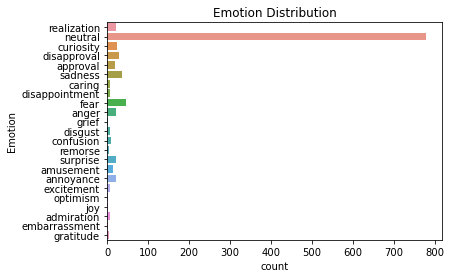

In [44]:
sns.countplot(data = df_fake_negative, y = 'emotion_2').set(title = "Emotion Distribution", ylabel= "Emotion")

There is a lot of neutrally connotated content. To look closely at the other emotions, the neutral ones will be removed from the plot.

In [45]:
fakes_negative_without_neutral = df_fake_negative[df_fake_negative["emotion_2"]!='neutral']
fakes_negative_without_neutral.shape

(323, 7)

[Text(0, 0.5, 'Emotion')]

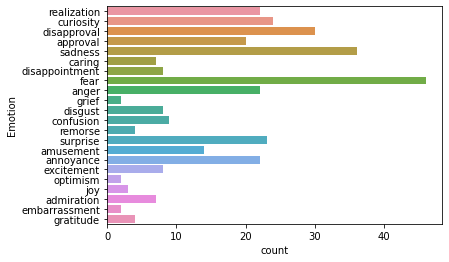

In [47]:
sns.countplot(data = fakes_negative_without_neutral, y = 'emotion_2').set(ylabel= "Emotion")

### Positives Emotion Analysis

First the NRCLex function emotion will be exploited.

In [48]:
df_fake_positive['emotions'] = df_fake_positive['content'].apply(lambda x: NRCLex(x).affect_frequencies)
df_fake_positive.head(3)

C:\Users\chiar\AppData\Local\Temp\ipykernel_14548\3694470583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake_positive['emotions'] = df_fake_positive['content'].apply(lambda x: NRCLex(x).affect_frequencies)


,content,fake,processed_text,stemmer,sentiment_score,emotions
3321,the greatest trick the u s cdc ever pulled was...,1,"[greatest, trick, u, cdc, ever, pulled, convin...","[greatest, trick, u, cdc, ever, pull, convinc,...",0.0747,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
3324,photos show democratic presidential nominee jo...,1,"[photos, show, democratic, presidential, nomin...","[photo, show, democrat, presidenti, nomine, jo...",0.3612,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
3325,facebook posts shared tens of thousands of tim...,1,"[facebook, posts, shared, tens, thousands, tim...","[facebook, post, share, ten, thousand, time, d...",0.2251,"{'fear': 0.1111111111111111, 'anger': 0.111111..."


In [49]:
# create a df with only the content and the emotion
fakes_positive_emotions = pd.concat([df_fake_positive.content, df_fake_positive['emotions'].apply(pd.Series)], axis = 1)
fakes_positive_emotions = fakes_positive_emotions.drop(['anticip'], axis=1)
print(fakes_positive_emotions.shape)
fakes_positive_emotions.head(3)

(595, 11)


,content,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
3321,the greatest trick the u s cdc ever pulled was...,0.000000,0.000000,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.0,NaN
3324,photos show democratic presidential nominee jo...,0.000000,0.000000,0.400000,0.000000,0.400000,0.000000,0.000000,0.000000,0.0,0.200000
3325,facebook posts shared tens of thousands of tim...,0.111111,0.111111,0.111111,0.000000,0.222222,0.111111,0.111111,0.111111,0.0,0.111111


In [50]:
# mean value for each emotion
np.mean(fakes_positive_emotions)

c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


fear            0.086041
anger           0.030404
trust           0.132607
surprise        0.054390
positive        0.267183
negative        0.163241
sadness         0.045904
disgust         0.039862
joy             0.048783
anticipation    0.173098
dtype: float64

The emotion with the highest average score is the *positive* one, followed by the *anticipation*, *negative* and *trust* ones.

Then the other algorithm using transformers is exploited.

The following is a time-consuming cell ($\approx$ 2 min).

In [8]:
# computing the emotion for the positives dataset
run_time_consuming_ops = False

if run_time_consuming_ops:

    df_fake_positive['emotion_2'] = df_fake_positive['content'].apply(get_emotion_label)
    print('Time consuming operations performed!')

else:

    df_fake_positive = pd.read_csv('df_fake_positive.csv')
    print('Time-saving file loaded!')

Time-saving file loaded!


In [10]:
df_fake_positive.head(3)

,content,fake,processed_text,stemmer,sentiment_score,emotions,emotion_2
0,the greatest trick the u s cdc ever pulled was...,1,"['greatest', 'trick', 'u', 'cdc', 'ever', 'pul...","['greatest', 'trick', 'u', 'cdc', 'ever', 'pul...",0.0747,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",neutral
1,photos show democratic presidential nominee jo...,1,"['photos', 'show', 'democratic', 'presidential...","['photo', 'show', 'democrat', 'presidenti', 'n...",0.3612,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",neutral
2,facebook posts shared tens of thousands of tim...,1,"['facebook', 'posts', 'shared', 'tens', 'thous...","['facebook', 'post', 'share', 'ten', 'thousand...",0.2251,"{'fear': 0.1111111111111111, 'anger': 0.111111...",neutral


[Text(0.5, 1.0, 'Emotion Distribution'), Text(0, 0.5, 'Emotion')]

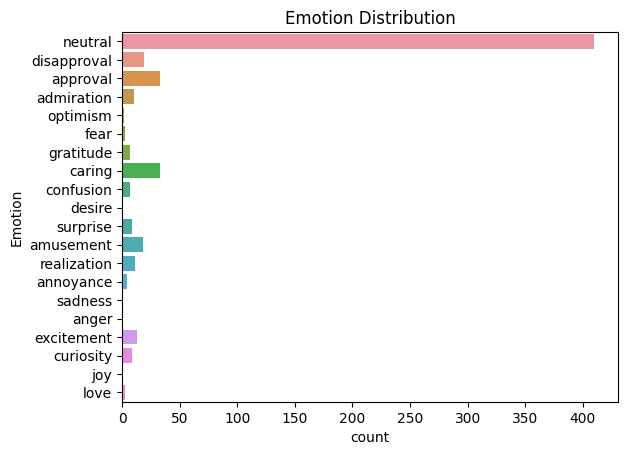

In [11]:
sns.countplot(data = df_fake_positive, y = 'emotion_2').set(title = "Emotion Distribution", ylabel= "Emotion")

There is a lot of neutrally connotated content. To look closely at the other emotions, the neutral ones will be removed from the plot.

In [12]:
fakes_positive_without_neutral = df_fake_positive[df_fake_positive["emotion_2"]!='neutral']
fakes_positive_without_neutral.shape

(185, 7)

[Text(0, 0.5, 'Emotion')]

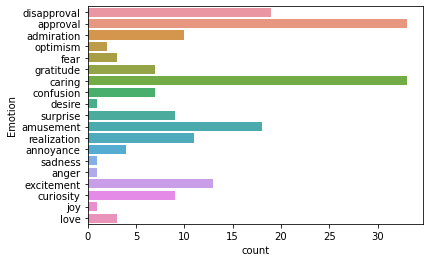

In [33]:
sns.countplot(data = fakes_positive_without_neutral, y = 'emotion_2').set(ylabel= "Emotion")

### Neutrals Emotion Analysis
First the NRCLex function emotion will be exploited.

In [60]:
df_fake_neutral['emotions'] = df_fake_neutral['content'].apply(lambda x: NRCLex(x).affect_frequencies)
df_fake_neutral.head(3)

C:\Users\chiar\AppData\Local\Temp\ipykernel_14548\3941606880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake_neutral['emotions'] = df_fake_neutral['content'].apply(lambda x: NRCLex(x).affect_frequencies)


,content,fake,processed_text,stemmer,sentiment_score,emotions
3318,either masks work or they don t if masks work ...,1,"[either, masks, work, masks, work, physical, d...","[either, mask, work, mask, work, physic, dista...",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
3319,the rt pcr test for the virus that causes covi...,1,"[pcr, test, virus, causes, covid, 19, detects,...","[pcr, test, viru, caus, covid, 19, detect, hum...",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
3320,the governor of maine has ordered restaurant s...,1,"[governor, maine, ordered, restaurant, staff, ...","[governor, main, order, restaur, staff, wear, ...",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."


In [61]:
# create a df with only the content and the emotion
fakes_neutral_emotions = pd.concat([df_fake_neutral.content, df_fake_neutral['emotions'].apply(pd.Series)], axis = 1)
fakes_neutral_emotions = fakes_neutral_emotions.drop(['anticip'], axis=1)
print(fakes_neutral_emotions.shape)
fakes_neutral_emotions.head(3)

(631, 11)


,content,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
3318,either masks work or they don t if masks work ...,0.0,0.0,0.50,0.0,0.5,0.00,0.0,0.0,0.0,NaN
3319,the rt pcr test for the virus that causes covi...,0.0,0.0,0.00,0.0,0.0,0.50,0.0,0.0,0.0,0.5
3320,the governor of maine has ordered restaurant s...,0.0,0.0,0.75,0.0,0.0,0.25,0.0,0.0,0.0,NaN


In [62]:
# mean value for each emotion
np.mean(fakes_neutral_emotions)

c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


fear            0.053524
anger           0.016870
trust           0.123353
surprise        0.034035
positive        0.314102
negative        0.106991
sadness         0.034640
disgust         0.015178
joy             0.032842
anticipation    0.285540
dtype: float64

The emotions with highest average are *positive* and *anticipation*.

Then the other algorithm using transformers is exploited.

The following is a time-consuming cell ($\approx$ 2 min).

In [14]:
# computing the emotion for the negatives dataset
run_time_consuming_ops = False

if run_time_consuming_ops:

    df_fake_neutral['emotion_2'] = df_fake_neutral['content'].apply(get_emotion_label)
    print('Time consuming operations performed!')

else:

    df_fake_neutral = pd.read_csv('df_fake_neutral.csv')
    print('Time-saving file loaded!')

Time-saving file loaded!


In [3]:
df_fake_neutral.head(3)

,content,fake,processed_text,stemmer,sentiment_score,emotions,emotion_2
0,either masks work or they don t if masks work ...,1,"['either', 'masks', 'work', 'masks', 'work', '...","['either', 'mask', 'work', 'mask', 'work', 'ph...",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",confusion
1,the rt pcr test for the virus that causes covi...,1,"['pcr', 'test', 'virus', 'causes', 'covid', '1...","['pcr', 'test', 'viru', 'caus', 'covid', '19',...",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",approval
2,the governor of maine has ordered restaurant s...,1,"['governor', 'maine', 'ordered', 'restaurant',...","['governor', 'main', 'order', 'restaur', 'staf...",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",neutral


[Text(0.5, 1.0, 'Emotion Distribution'), Text(0, 0.5, 'Emotion')]

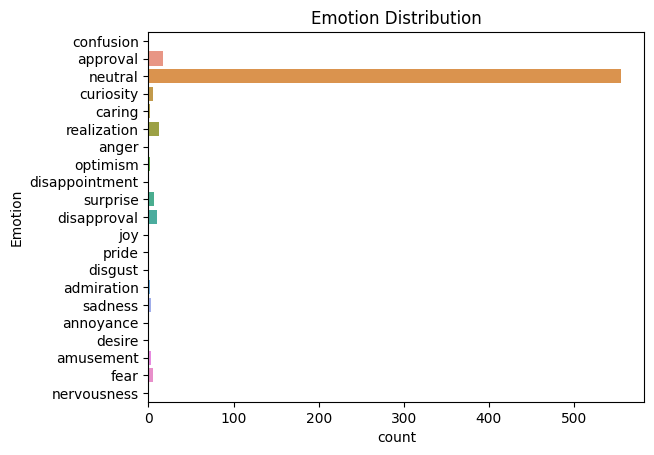

In [4]:
sns.countplot(data = df_fake_neutral, y = 'emotion_2').set(title = "Emotion Distribution", ylabel= "Emotion")

There is a lot of neutrally connotated content. To look closely at the other emotions, the neutral ones will be removed from the plot.

In [16]:
fakes_neutral_without_neutral = df_fake_neutral[df_fake_neutral["emotion_2"]!='neutral']
fakes_neutral_without_neutral.shape

(76, 7)

[Text(0, 0.5, 'Emotion')]

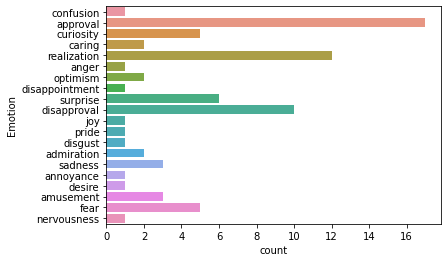

In [34]:
sns.countplot(data = fakes_neutral_without_neutral, y = 'emotion_2').set( ylabel= "Emotion")

## Real News Sentiment Analysis

In this subsection it is performed the sentiment analysis on the dataset only containing real news and tweets.  The first step is the stemming:

In [74]:
# stemmization
from nltk.stem import PorterStemmer
ps = PorterStemmer()
df_real['stemmer'] = df_real['processed_text'].apply(lambda x: [ps.stem(i) for i in x if i != ''])

C:\Users\chiar\AppData\Local\Temp\ipykernel_14548\2129352840.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['stemmer'] = df_real['processed_text'].apply(lambda x: [ps.stem(i) for i in x if i != ''])


To perform the sentiment analysis as an unsupervised task, it is used the Vader Lexicon. 

In [75]:
from nltk.tokenize import word_tokenize
df_real['sentiment_score'] = df_real['stemmer'].apply(lambda x: sum([ sia.polarity_scores(i)['compound'] for i in word_tokenize( ' '.join(x) )]) )

C:\Users\chiar\AppData\Local\Temp\ipykernel_14548\3810609357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['sentiment_score'] = df_real['stemmer'].apply(lambda x: sum([ sia.polarity_scores(i)['compound'] for i in word_tokenize( ' '.join(x) )]) )


In [76]:
# number of positives, neutrals and negatives 
print('positives: ', len(df_real[df_real["sentiment_score"]>0]))
print('neutrals: ', len(df_real[df_real["sentiment_score"]==0]))
print('negatives: ', len(df_real[df_real["sentiment_score"]<0]))

positives:  31616
neutrals:  16413
negatives:  16324


To further the investigation into the connotation of the records in the dataset, the idea is to perform emotion analysis, for each of the three sentiments separately. 

In [77]:
# create the three datasets divided by the sentiment score: positive, negative and neutral
df_real_positive = df_real[df_real["sentiment_score"]>0]
df_real_neutral = df_real[df_real["sentiment_score"]==0]
df_real_negative = df_real[df_real["sentiment_score"]<0]

### Negatives Emotion Analysis

For the emotion analysis the algorithms used are two. The first one is the following, by using the NRCLex function:

In [78]:
df_real_negative['emotions'] = df_real_negative['content'].apply(lambda x: NRCLex(x).affect_frequencies)
df_real_negative.head(3)

C:\Users\chiar\AppData\Local\Temp\ipykernel_14548\1728735399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real_negative['emotions'] = df_real_negative['content'].apply(lambda x: NRCLex(x).affect_frequencies)


,content,fake,processed_text,stemmer,sentiment_score,emotions
1,why approving a covid 19 vaccine too early cou...,0,"[approving, covid, 19, vaccine, early, could, ...","[approv, covid, 19, vaccin, earli, could, caus...",-0.1019,"{'fear': 0.1111111111111111, 'anger': 0.0, 'an..."
2,not sure you have covid 19 here are the sympto...,0,"[sure, covid, 19, symptoms, coronavirus, flu, ...","[sure, covid, 19, symptom, coronaviru, flu, al...",-0.0636,"{'fear': 0.5, 'anger': 0.0, 'anticip': 0.0, 't..."
3,flu study highlights difficulty of achieving c...,0,"[flu, study, highlights, difficulty, achieving...","[flu, studi, highlight, difficulti, achiev, co...",-0.0418,"{'fear': 0.2857142857142857, 'anger': 0.142857..."
4,resign or return the dilemma facing classroom ...,0,"[resign, return, dilemma, facing, classroom, t...","[resign, return, dilemma, face, classroom, tea...",-0.5179,"{'fear': 0.2, 'anger': 0.2, 'anticip': 0.0, 't..."
7,despite new safety guidelines experts say movi...,0,"[despite, new, safety, guidelines, experts, sa...","[despit, new, safeti, guidelin, expert, say, m...",-0.2732,"{'fear': 0.3333333333333333, 'anger': 0.0, 'an..."


In [79]:
# create a df with only the content and the emotion
reals_negative_emotions = pd.concat([df_real_negative.content, df_real_negative['emotions'].apply(pd.Series)], axis = 1)
reals_negative_emotions = reals_negative_emotions.drop(['anticip'], axis=1)
print(reals_negative_emotions.shape)
reals_negative_emotions.head(3)

(16324, 11)


,content,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
1,why approving a covid 19 vaccine too early cou...,0.111111,0.000000,0.111111,0.111111,0.333333,0.111111,0.000000,0.0,0.111111,0.111111
2,not sure you have covid 19 here are the sympto...,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,NaN
3,flu study highlights difficulty of achieving c...,0.285714,0.142857,0.000000,0.000000,0.142857,0.285714,0.142857,0.0,0.000000,NaN


In [80]:
# mean value for each emotion
np.mean(reals_negative_emotions)

c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


fear            0.128183
anger           0.059571
trust           0.110019
surprise        0.031190
positive        0.175375
negative        0.212488
sadness         0.093511
disgust         0.053974
joy             0.028924
anticipation    0.147865
dtype: float64

The highest emotion on average is the *negative* one, followed by the *positive*, *anticipation*, *fear* and *trust* ones.

The next algorithm exploited is built upon the transformers library, and it uses a model called *EmoRoBERTa*.

The following is a time-consuming cell ($\approx$ 45 min).

The computation of this algorithm tends to be very slow. If the the file containing the result of this operations is available, `run_time_consuming_ops = False` can be used, and the time-consuming operations won't be executed, since the cell will simply load the result file to save time. 
If you want to run the time-consuming operations anyway, set `run_time_consuming_ops = True`.

In [18]:
# computing the emotion for the negatives dataset
run_time_consuming_ops = False

if run_time_consuming_ops:

    df_real_negative['emotion_2'] = df_real_negative['content'].apply(get_emotion_label)
    print('Time consuming operations performed!')

else:

    df_real_negative = pd.read_csv('df_real_negative.csv')
    print('Time-saving file loaded!')

Time-saving file loaded!


In [19]:
df_real_negative.head(3)

,content,fake,processed_text,stemmer,sentiment_score,emotions,emotion_2
0,why approving a covid 19 vaccine too early cou...,0,"['approving', 'covid', '19', 'vaccine', 'early...","['approv', 'covid', '19', 'vaccin', 'earli', '...",-0.1019,"{'fear': 0.1111111111111111, 'anger': 0.0, 'an...",confusion
1,not sure you have covid 19 here are the sympto...,0,"['sure', 'covid', '19', 'symptoms', 'coronavir...","['sure', 'covid', '19', 'symptom', 'coronaviru...",-0.0636,"{'fear': 0.5, 'anger': 0.0, 'anticip': 0.0, 't...",confusion
2,flu study highlights difficulty of achieving c...,0,"['flu', 'study', 'highlights', 'difficulty', '...","['flu', 'studi', 'highlight', 'difficulti', 'a...",-0.0418,"{'fear': 0.2857142857142857, 'anger': 0.142857...",neutral


[Text(0.5, 1.0, 'Emotion Distribution'), Text(0, 0.5, 'Emotion')]

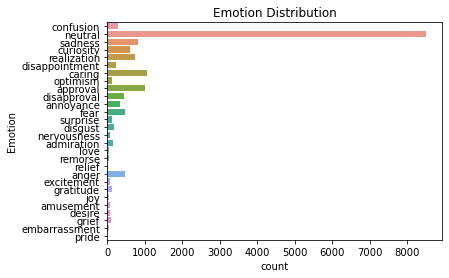

In [20]:
sns.countplot(data = df_real_negative, y = 'emotion_2').set(title = "Emotion Distribution", ylabel= "Emotion")

There is a lot of neutrally connotated content. To look closely at the other emotions, the neutral ones will be removed from the plot.

In [21]:
reals_negative_without_neutral = df_real_negative[df_real_negative["emotion_2"]!='neutral']
reals_negative_without_neutral.shape

(7820, 7)

[Text(0, 0.5, 'Emotion')]

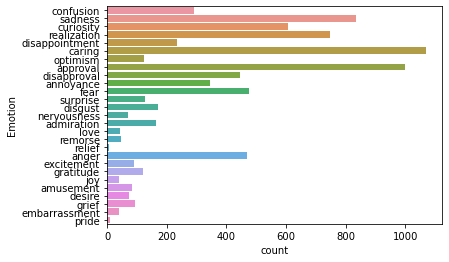

In [36]:
sns.countplot(data = reals_negative_without_neutral, y = 'emotion_2').set(ylabel= "Emotion")

### Positives Emotion Analysis
First the NRCLex function emotion will be exploited.

In [87]:
df_real_positive['emotions'] = df_real_positive['content'].apply(lambda x: NRCLex(x).affect_frequencies)
df_real_positive.head(3)

C:\Users\chiar\AppData\Local\Temp\ipykernel_14548\3687857905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real_positive['emotions'] = df_real_positive['content'].apply(lambda x: NRCLex(x).affect_frequencies)


,content,fake,processed_text,stemmer,sentiment_score,emotions
10,fast isn t always better what to know about ri...,0,"[fast, always, better, know, rise, rapid, coro...","[fast, alway, better, know, rise, rapid, coron...",0.4404,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
13,how to safely sanitize every type of face mask,0,"[safely, sanitize, every, type, face, mask]","[safe, sanit, everi, type, face, mask]",0.4404,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
14,suicidal ideation is increasing during covid 1...,0,"[suicidal, ideation, increasing, covid, 19, be...","[suicid, ideat, increas, covid, 19, best, cope]",0.6369,"{'fear': 0.2, 'anger': 0.2, 'anticip': 0.0, 't..."
31,can secondhand smoke transmit the novel corona...,0,"[secondhand, smoke, transmit, novel, coronavirus]","[secondhand, smoke, transmit, novel, coronaviru]",0.3182,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
37,people caring for grandchildren face high risk...,0,"[people, caring, grandchildren, face, high, ri...","[peopl, care, grandchildren, face, high, risk,...",0.2207,"{'fear': 0.14285714285714285, 'anger': 0.0, 'a..."


In [88]:
# create a df with only the content and the emotion
reals_positive_emotions = pd.concat([df_real_positive.content, df_real_positive['emotions'].apply(pd.Series)], axis = 1)
reals_positive_emotions = reals_positive_emotions.drop(['anticip'], axis=1)
print(reals_positive_emotions.shape)
reals_positive_emotions.head(3)

(31616, 11)


,content,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
10,fast isn t always better what to know about ri...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
13,how to safely sanitize every type of face mask,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
14,suicidal ideation is increasing during covid 1...,0.2,0.2,0.0,0.0,0.0,0.2,0.2,0.2,0.0,NaN


In [89]:
# mean value for each emotion
np.mean(reals_positive_emotions)

c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


fear            0.064598
anger           0.025805
trust           0.172235
surprise        0.030523
positive        0.325881
negative        0.097522
sadness         0.044906
disgust         0.019824
joy             0.078366
anticipation    0.179660
dtype: float64

The highest emotions on average are *positive*, *trust* and *anticipation*.

Then the other algorithm using transformers is exploited.

The following is a time-consuming cell ($\approx$ 65 min).

In [37]:
# computing the emotion for the positives dataset
run_time_consuming_ops = False

if run_time_consuming_ops:

    df_real_positive['emotion_2'] = df_real_positive['content'].apply(get_emotion_label)
    print('Time consuming operations performed!')

else:

    df_real_positive = pd.read_csv('df_real_positive.csv')
    print('Time-saving file loaded!')

Time-saving file loaded!


In [38]:
df_real_positive.head(3)

,content,fake,processed_text,stemmer,sentiment_score,emotions,emotion_2
0,fast isn t always better what to know about ri...,0,"['fast', 'always', 'better', 'know', 'rise', '...","['fast', 'alway', 'better', 'know', 'rise', 'r...",0.4404,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",realization
1,how to safely sanitize every type of face mask,0,"['safely', 'sanitize', 'every', 'type', 'face'...","['safe', 'sanit', 'everi', 'type', 'face', 'ma...",0.4404,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",neutral
2,suicidal ideation is increasing during covid 1...,0,"['suicidal', 'ideation', 'increasing', 'covid'...","['suicid', 'ideat', 'increas', 'covid', '19', ...",0.6369,"{'fear': 0.2, 'anger': 0.2, 'anticip': 0.0, 't...",confusion


[Text(0.5, 1.0, 'Emotion Distribution'), Text(0, 0.5, 'Emotion')]

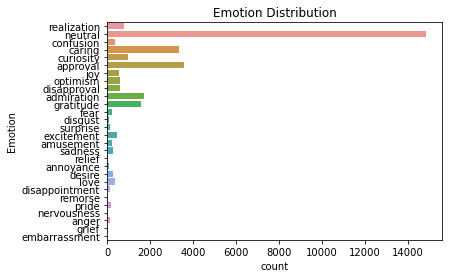

In [39]:
sns.countplot(data = df_real_positive, y = 'emotion_2').set(title = "Emotion Distribution", ylabel= "Emotion")

There is a lot of neutrally connotated content. To look closely at the other emotions, the neutral ones will be removed from the plot.

In [40]:
reals_positive_without_neutral = df_real_positive[df_real_positive["emotion_2"]!='neutral']
reals_positive_without_neutral.shape

(16786, 7)

[Text(0, 0.5, 'Emotion')]

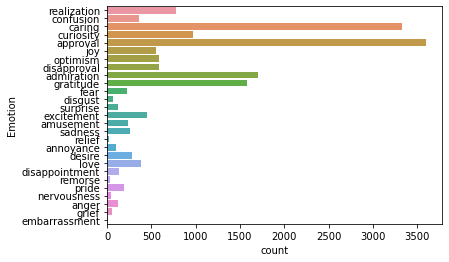

In [42]:
sns.countplot(data = reals_positive_without_neutral, y = 'emotion_2').set( ylabel= "Emotion")

### Neutrals Emotion Analysis
First the NRCLex function emotion will be exploited.

In [96]:
df_real_neutral['emotions'] = df_real_neutral['content'].apply(lambda x: NRCLex(x).affect_frequencies)
df_real_neutral.head(3)

C:\Users\chiar\AppData\Local\Temp\ipykernel_14548\3172934519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real_neutral['emotions'] = df_real_neutral['content'].apply(lambda x: NRCLex(x).affect_frequencies)


,content,fake,processed_text,stemmer,sentiment_score,emotions
0,what we can learn from the resurgence of covid...,0,"[learn, resurgence, covid, 19, spain]","[learn, resurg, covid, 19, spain]",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
5,fda approves 5 covid 19 test that gives result...,0,"[fda, approves, 5, covid, 19, test, gives, res...","[fda, approv, 5, covid, 19, test, give, result...",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
6,staying 6 feet apart often isn t enough during...,0,"[staying, 6, feet, apart, often, enough, covid...","[stay, 6, feet, apart, often, enough, covid, 1...",0.0,"{'fear': 0.3333333333333333, 'anger': 0.0, 'an..."
8,yes you can get covid 19 again what to know,0,"[yes, get, covid, 19, know]","[ye, get, covid, 19, know]",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
9,blood thinners blood pressure meds may improve...,0,"[blood, thinners, blood, pressure, meds, may, ...","[blood, thinner, blood, pressur, med, may, imp...",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."


In [97]:
# create a df with only the content and the emotion
reals_neutral_emotions = pd.concat([df_real_neutral.content, df_real_neutral['emotions'].apply(pd.Series)], axis = 1)
reals_neutral_emotions = reals_neutral_emotions.drop(['anticip'], axis=1)
print(reals_neutral_emotions.shape)
reals_neutral_emotions.head(3)

(16413, 11)


,content,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,what we can learn from the resurgence of covid...,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,NaN
5,fda approves 5 covid 19 test that gives result...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,NaN
6,staying 6 feet apart often isn t enough during...,0.333333,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.0,NaN


In [98]:
# mean value for each emotion
np.mean(reals_neutral_emotions)

c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\chiar\anaconda3\envs\text_env\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


fear            0.064767
anger           0.021571
trust           0.148477
surprise        0.024726
positive        0.277779
negative        0.100797
sadness         0.042376
disgust         0.018489
joy             0.031342
anticipation    0.267240
dtype: float64

The highest emotions on average are *positive*, *anticipation* and *trust*.

Then the other algorithm using transformers is exploited.

The following is a time-consuming cell ($\approx$ 30 min).

In [23]:
# computing the emotion for the neutrals dataset
run_time_consuming_ops = False

if run_time_consuming_ops:

    df_real_neutral['emotion_2'] = df_real_neutral['content'].apply(get_emotion_label)
    print('Time consuming operations performed!')

else:

    df_real_neutral = pd.read_csv('df_real_neutral.csv')
    print('Time-saving file loaded!')

Time-saving file loaded!


In [24]:
df_real_neutral.head(3)

,content,fake,processed_text,stemmer,sentiment_score,emotions,emotion_2
0,what we can learn from the resurgence of covid...,0,"['learn', 'resurgence', 'covid', '19', 'spain']","['learn', 'resurg', 'covid', '19', 'spain']",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",neutral
1,fda approves 5 covid 19 test that gives result...,0,"['fda', 'approves', '5', 'covid', '19', 'test'...","['fda', 'approv', '5', 'covid', '19', 'test', ...",0.0,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...",neutral
2,staying 6 feet apart often isn t enough during...,0,"['staying', '6', 'feet', 'apart', 'often', 'en...","['stay', '6', 'feet', 'apart', 'often', 'enoug...",0.0,"{'fear': 0.3333333333333333, 'anger': 0.0, 'an...",neutral


[Text(0.5, 1.0, 'Emotion Distribution'), Text(0, 0.5, 'Emotion')]

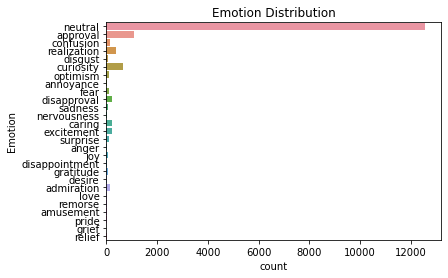

In [25]:
sns.countplot(data = df_real_neutral, y = 'emotion_2').set(title = "Emotion Distribution", ylabel= "Emotion")

There is a lot of neutrally connotated content. To look closely at the other emotions, the neutral ones will be removed from the plot.

In [26]:
reals_neutral_without_neutral = df_real_neutral[df_real_neutral["emotion_2"]!='neutral']
reals_neutral_without_neutral.shape

(3833, 7)

[Text(0, 0.5, 'Emotion')]

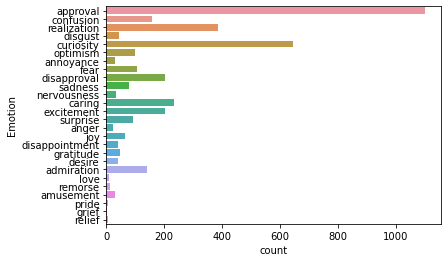

In [35]:
sns.countplot(data = reals_neutral_without_neutral, y = 'emotion_2').set(ylabel= "Emotion")